In [ ]:
!pip install sportsipy
!pip install sportsreference
!pip install category_encoders==2

In [95]:
from sportsreference.ncaab.schedule import Schedule
from sportsipy.ncaab.teams import Teams
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import graphviz
from IPython.display import Image
from sklearn.tree import export_graphviz

In [3]:
# instantiate teams class
teams = Teams()

# define function to get team abbreviations
def get_teams(teams):
    l=[]
    for team in teams:
        l.append(team.abbreviation)
    return l

# get list of all teams for API (fetch data)
team_list = get_teams(teams)

In [4]:
# examine list 
print('THE FIRST 5 TEAMS ARE: {}'.format(team_list[0:5]))
length = len(team_list)
print('THERE ARE {} NCAAB TEAMS'.format(length))

THE FIRST 5 TEAMS ARE: ['ABILENE-CHRISTIAN', 'AIR-FORCE', 'AKRON', 'ALABAMA-AM', 'ALABAMA-BIRMINGHAM']
THERE ARE 356 NCAA TEAMS


In [5]:
# define function to fetch data for each team
def get_agg_data_from_list(team_list,year):
    

    length = len(team_list)

    # Make an empty dataframe to hold results
    list_data = pd.DataFrame()

    for i in range(0,length):

        # Loop through each team and append fetched data
        try:
            team_data = Schedule(team_list[i], year = year).dataframe                                                                   
            team_data['team'] = team_list[i]
        except:
            continue

        # Append data to the results dataframe
        list_data = list_data.append(team_data)

    return list_data

# set feature matrix
features = ['arena','location','opponent_abbr', 'opponent_conference',
       'opponent_rank', 'overtimes', 'points_against', 'points_for',
       'season_losses', 'season_wins', 'streak', 'time', 'type']

# set target vector
target = 'target'

# call function with list of teams
data = get_agg_data_from_list(team_list,'2019')
data = data.reset_index().set_index(['game','team']).sort_index()

# shift target so model can predict next game
data.loc[:,'target'] = data.groupby(level='team')['result'].apply(lambda x: x.shift(-1))

# split data into feature/target
tmp = data.dropna().copy()
X = tmp[features].copy()
y = tmp[target].copy()

X.head()

arena location  ...    time type
game team                                                        ...             
1    BRIGHAM-YOUNG                Lawlor Events Center     Away  ...  11:00p  Reg
     CAL-STATE-BAKERSFIELD  Ed & Rae Schollmaier Arena     Away  ...   9:00p  Reg
     CITADEL                       Littlejohn Coliseum     Away  ...   7:00p  Reg
     DUKE                      Bankers Life Fieldhouse  Neutral  ...   9:30p  Reg
     EASTERN-WASHINGTON                   Carrier Dome     Away  ...   7:00p  Reg

[5 rows x 13 columns]

In [6]:
# split data for train/test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [13]:
# get baseline accuracy 
print('THE BASELINE ACCURACY IS: {}'.format(y_train['target'].value_counts(normalize=True).max()))

THE BASELINE ACCURACY IS: 0.5639880952380952


In [74]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier()
)

model.fit(X_train,np.ravel(y_train['target']))

x = accuracy_score(model.predict(X_test),y_test)

print('FOREST MODEL ACCURACY: {}'.format(x))

FOREST MODEL ACCURACY: 0.6369047619047619


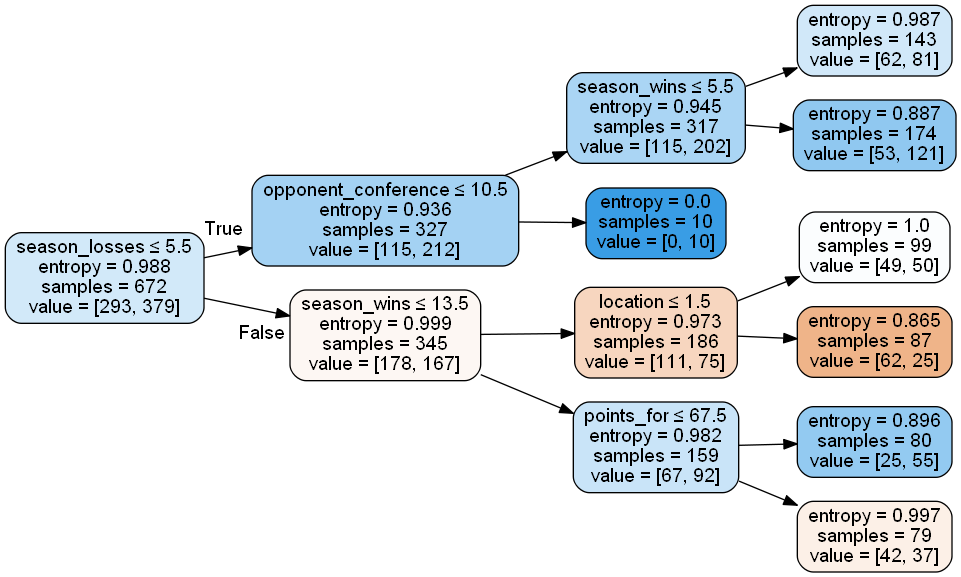

      Feature                 Importance
 1. points_for          (0.1274878120560273)
 2. arena               (0.11313797702589108)
 3. season_wins         (0.10958815143241356)
 4. points_against      (0.10885495641133332)
 5. season_losses       (0.10168438956912074)
 6. opponent_rank       (0.09573104764575012)
 7. opponent_abbr       (0.08970383814432088)
 8. time                (0.08677813588299292)
 9. streak              (0.06910668113142196)
10. opponent_conference (0.05571160347965733)
11. location            (0.028830202728949178)
12. overtimes           (0.007243023196408457)
13. type                (0.006142181295713284)


In [96]:
def plot_tree_classifier(clf, feature_names=None):
    dot_data = export_graphviz(
        clf,
        out_file=None,
        feature_names=feature_names,
        filled=True,
        rounded=True,
        special_characters=True,
        rotate=True)

    return Image(graphviz.Source(dot_data).pipe(format='png'))

def rank_features_by_importance(importances, feature_names):
    indices = np.argsort(importances)[::-1]
    max_feature_name_length = max([len(feature) for feature in feature_names])

    print('      Feature{space: <{padding}}      Importance'.format(padding=max_feature_name_length - 8, space=' '))

    for x_train_i in range(len(importances)):
        print('{number:>2}. {feature: <{padding}} ({importance})'.format(
            number=x_train_i + 1,
            padding=max_feature_name_length,
            feature=feature_names[indices[x_train_i]],
            importance=importances[indices[x_train_i]]))

oe = OrdinalEncoder()
oe.fit(X_train)
XT_train = oe.transform(X_train)

# This is to get consistent results between each run.
clf_random_state = 0

simple_clf = DecisionTreeClassifier(
    max_depth=3,
    criterion='entropy',
    random_state=clf_random_state)
simple_clf.fit(XT_train, np.ravel(y_train['target']))

display(plot_tree_classifier(simple_clf, feature_names=features))

imp = model.named_steps['randomforestclassifier'].feature_importances_
rank_features_by_importance(imp,features)